In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from timeit import default_timer
import lightgbm as lgb

import pickle

import warnings
warnings.filterwarnings('ignore')

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import model_selection

from sklearn.model_selection import cross_val_score
from sklearn import metrics

from itertools import permutations, combinations

from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, average_precision_score,precision_recall_fscore_support
    
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import GradientBoostingClassifier

## Download PAMAP2_Dataset

Run the following commands on your command line:

- wget http://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip
- sudo apt-get install unzip
- mkdir destination_directory
- unzip PAMAP2_Dataset.zip -d destination_directory

## Import Data

In [9]:
cols = ["time","activity","heart_rate",
        "h_temp","h_x1","h_y1","h_z1","h_x2","h_y2","h_z2","h_g1","h_g2","h_g3","h_m1","h_m2","h_m3","h_r1","h_r2","h_r3","h_r4",
        "c_temp","c_x1","c_y1","c_z1","c_x2","c_y2","c_z2","c_g1","c_g2","c_g3","c_m1","c_m2","c_m3","c_r1","c_r2","c_r3","c_r4",
        "a_temp","a_x1","a_y1","a_z1","a_x2","a_y2","a_z2","a_g1","a_g2","a_g3","a_m1","a_m2","a_m3","a_r1","a_r2","a_r3","a_r4"]

Set the variable destination_directory to path where you unziped the dataset.

In [16]:
import glob
import re

destination_directory = r'./' # use the destination directory you unziped the dataset to when following the instructions above.


p = re.compile("(\d+)\.")

path = destination_directory + r'PAMAP2_Dataset/Protocol/'

allFiles = glob.glob(path + "/*.dat")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    m = p.search(file_)
    df = pd.read_csv(file_,index_col=None, header=None, delim_whitespace=True)
    df.columns = cols
    df['subject'] = m.groups()[0]
    list_.append(df)
    
frame = pd.concat(list_)

In [14]:
import pickle
# ## To save the data
with open('RawDataFrame.pickle', 'wb') as f:
    pickle.dump([frame, cols], f)# To load the data

# with open("RawDataFrame.pickle", 'rb') as picklefile: 
#     frame, cols = pickle.load(picklefile)

## Prepare Data

In [15]:
# Drop sensor magnetometer data - Deemed irrelevant per dataset readme file
data = frame.drop(["h_r1", "h_r2", "h_r3", "h_r4",
                   "a_r1","a_r2","a_r3","a_r4",
                  "c_r1", "c_r2", "c_r3", "c_r4"],axis=1)

# Drop 2nd accelerometer data which becomes saturated
data = frame.drop(["h_x2","h_y2","h_z2",
                   "c_x2","c_y2","c_z2",
                   "a_x2","a_y2","a_z2"],axis=1)


# Drop samples for which activity was not monitored
data = data[frame.activity!=0]

In [16]:
del frame

In [17]:
idx = [1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,19,20,24]
val = ['lie','sit','stand','walk','run','cycle',
      'nordic','tv','pc','drive','asc','desc',
      'vacuum','iron','fold','clean','soccer','rope']
act_name = pd.DataFrame({'act_name':val},index=idx)

In [18]:
data['heart_rate'] = data['heart_rate'].fillna(method='bfill')
data = data.dropna()
data = data.join(act_name,on='activity',how='left')

## Data Exploration

In [19]:
data.shape

(1921430, 47)

In [20]:
data.act_name.value_counts()

iron      237902
walk      229709
lie       192290
stand     188984
sit       184645
nordic    184444
vacuum    174976
cycle     163302
asc       117094
desc      104865
run        95641
rope       47578
Name: act_name, dtype: int64

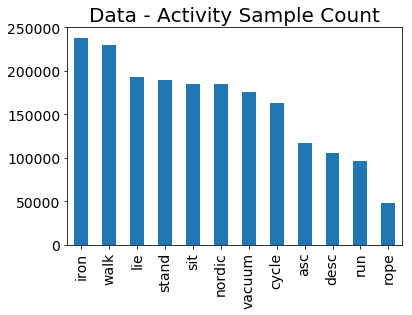

In [21]:
data.act_name.value_counts().plot('bar',fontsize=14)
plt.title('Data - Activity Sample Count',fontsize = 20)
plt.savefig('ActivitySampleCount.png')
plt.show()

In [22]:
data.subject.value_counts()

105    269311
108    259215
102    259128
106    248080
101    247208
107    230377
104    228385
103    173341
109      6385
Name: subject, dtype: int64

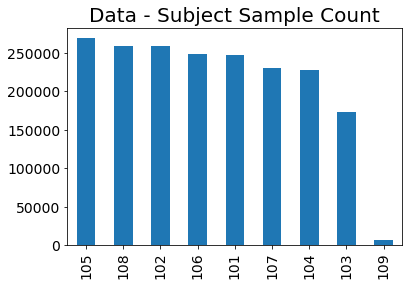

In [23]:
data.subject.value_counts().plot('bar',fontsize=14)
plt.title('Data - Subject Sample Count',fontsize=20)
plt.savefig('SubjectSampleCount.png')
plt.show()


In [24]:
y = data['activity']
X = data
X_subject = data['subject']
X = X.drop(['activity','act_name','time','heart_rate','h_temp','c_temp','a_temp','subject'],axis=1)
del data

In [28]:
with open("Xy.pickle", 'wb') as picklefile: 
    pickle.dump([X,y,X_subject],picklefile)

## Modelling

In [29]:
# import pickle
# Load saved X,y data
with open("Xy.pickle", 'rb') as picklefile: 
    X, y, X_subject = pickle.load(picklefile)
    
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=4444,
                                                   stratify=y)

In [29]:
## Generate baseline classifiers
knn = KNeighborsClassifier(n_jobs=-1)
gaussNB = GaussianNB()
randForest = RandomForestClassifier(n_jobs=-1)
estimators = [knn,gaussNB,randForest]

### Estimators cross-validation

In [251]:
acc_score = []

for i,est in enumerate(estimators):
    #print(i)
    scores = cross_val_score(est,X_train,y_train,cv=5,scoring='accuracy',n_jobs=-1)
    acc_score.append(np.mean(scores))

acc_scoreCV = pd.DataFrame(acc_score,index=['knn','gaussNB','randForest'],columns=['accuracyCV'])
acc_scoreCV

with open("estimatorsCV_accuracy.pickle", 'wb') as picklefile: 
    pickle.dump(acc_scoreCV,picklefile)

In [35]:
f1_score = []

for i,est in enumerate(estimators):
    print('Estimator: ',i)
    start = default_timer()
    scores = cross_val_score(est,X_train,y_train,cv=5,scoring='f1_macro',n_jobs=2)
    f1_score.append(np.mean(scores))
    print('{:.2f}'.format(default_timer()-start))
    
f1_score = pd.DataFrame(f1_score,index=['knn','gaussNB','randForest'],columns=['f1_CV'])

with open("estimatorsCV_f1.pickle", 'wb') as picklefile: 
    pickle.dump(acc_scoreCV,picklefile)

In [259]:
# with open("estimatorsCV_accuracy.pickle", 'rb') as picklefile: 
#     acc_scoreCV = pickle.load(picklefile)
    
acc_scoreCV

,accuracyCV
knn,0.996169
gaussNB,0.757252
randForest,0.997543


### CV Accuracy for KNN and Random Forest is very good
Fit model on training data and examine performance on test data

In [252]:
# Fit classifiers on training data
%timeit knn.fit(X_train,y_train)
%timeit gaussNB.fit(X_train,y_train)
%timeit randForest.fit(X_train,y_train)

with open("estimatorsFitted.pickle", 'wb') as picklefile: 
    pickle.dump([knn,gaussNB,randForest],picklefile)

16.4 s ± 481 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.63 s ± 22.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 49s ± 3.62 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
# with open("estimatorsFitted.pickle", 'rb') as picklefile: 
#     knn,gaussNB,randForest = pickle.load(picklefile)

### Examine precision and recall

In [253]:
y_pred_knn = knn.predict(X_test)
y_pred_NB = gaussNB.predict(X_test)
#y_pred_t = tree.predict(X_test)
y_pred_rF = randForest.predict(X_test)

with open("Pred.pickle", 'wb') as picklefile: 
    pickle.dump([y_pred_knn,y_pred_NB,y_pred_rF],picklefile)

In [ ]:
# with open("Pred.pickle", 'rb') as picklefile: 
#     y_pred_knn,y_pred_NB,y_pred_rF = pickle.load(picklefile)

In [255]:
def print_classRep_confMat(y_true,y_pred):
    print(classification_report(y_true,y_pred))
    #print(confusion_matrix(y_true,y_pred))

In [256]:
print('\n KNN-------------')
print_classRep_confMat(y_test, y_pred_knn)
print('\n NaiveBayes-------------')
print_classRep_confMat(y_test, y_pred_NB)
# print('\n Trees-------------')
# print_classRep_confMat(y_test, y_pred_t)
print('\n RandomForest-------------')
print_classRep_confMat(y_test, y_pred_rF)


 KNN-------------
             precision    recall  f1-score   support

          1       1.00      1.00      1.00     63456
          2       1.00      1.00      1.00     60933
          3       1.00      1.00      1.00     62365
          4       0.99      1.00      0.99     75804
          5       1.00      1.00      1.00     31561
          6       1.00      1.00      1.00     53890
          7       0.99      0.99      0.99     60866
         12       1.00      0.99      1.00     38641
         13       1.00      0.99      1.00     34605
         16       1.00      1.00      1.00     57742
         17       1.00      1.00      1.00     78508
         24       1.00      1.00      1.00     15701

avg / total       1.00      1.00      1.00    634072


 NaiveBayes-------------
             precision    recall  f1-score   support

          1       0.97      0.92      0.94     63456
          2       0.85      0.80      0.83     60933
          3       0.64      0.82      0.72     623

### Examine ROC and AUC

In [254]:
knn_pp = knn.predict_proba(X_test)
NB_pp = gaussNB.predict_proba(X_test)
#t_pp = tree.predict_proba(X_test)
rF_pp = randForest.predict_proba(X_test)

with open("PredProbas.pickle", 'wb') as picklefile: 
    pickle.dump([knn_pp,NB_pp,rF_pp],picklefile)

In [ ]:
# with open("PredProbas.pickle", 'rb') as picklefile: 
#     knn_pp,NB_pp,rF_pp = pickle.load(picklefile)

In [257]:
def auc_roc_subplot(ax, y_test, pred_prob, model):
    num_labels = len(y_test.unique())
    roc_auc = 0
    for idx, label in zip(range(0,num_labels) , sorted(y_test.unique())):
        fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob[:,idx], pos_label=label)
        ax.plot(fpr,tpr,label=label)
        roc_auc += metrics.auc(fpr, tpr)

    roc_auc = roc_auc/num_labels

    ax.set_title('{:s} - ROC - AUC: {:0.2f}'.format(model,roc_auc),weight='bold')
    ax.set_ylim((0,1.2))
    ax.set_xlim((-0.2,1)) 

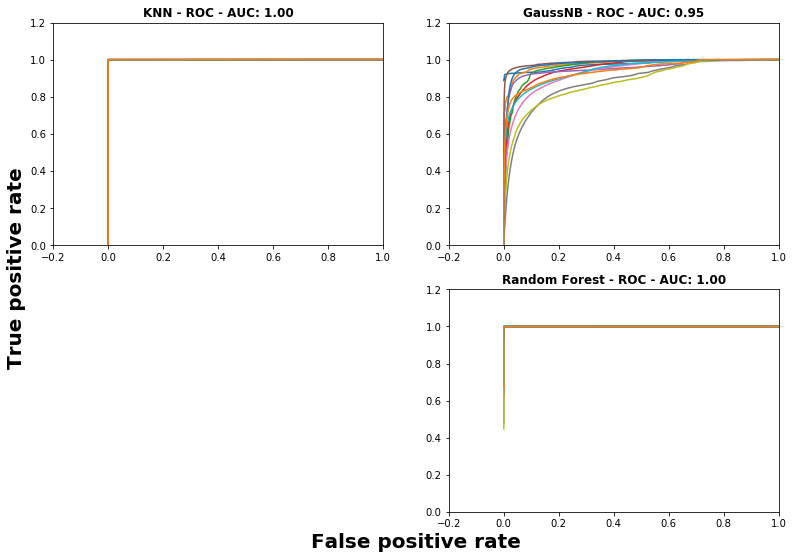

In [258]:
fig = plt.figure(figsize=(13,9))
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
#ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

auc_roc_subplot(ax1, y_test, knn_pp, 'KNN')
auc_roc_subplot(ax2, y_test, NB_pp, 'GaussNB')
#auc_roc_subplot(ax3, y_test, t_pp, 'Tree')
auc_roc_subplot(ax4, y_test, rF_pp, 'Random Forest')

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

ax.set_xlabel('False positive rate',size=20, weight='bold')
ax.set_ylabel('True positive rate',size=20, weight='bold')

plt.show()
#auc_roc_subplot(ax1, y_test, NB_pp, 'NB')

### Learning Curve

In [30]:
# Features belonging to wrist sensor
h = ['h_x1', 'h_y1', 'h_z1','h_g1', 'h_g2', 'h_g3', 'h_m1', 'h_m2', 'h_m3']
# Feauters belonging to chest sensor
c = ['c_x1', 'c_y1', 'c_z1','c_g1', 'c_g2', 'c_g3', 'c_m1', 'c_m2', 'c_m3']
# Features belonging to ankle sensor
a = ['a_x1', 'a_y1', 'a_z1','a_g1', 'a_g2', 'a_g3', 'a_m1', 'a_m2', 'a_m3']

acce= h+c+a

In [33]:
def my_scorer(y_true, y_pred=None, estimator=None, X=None,):
    if estimator is not None:
        y_pred = estimator.predict(X)
    f1 = metrics.f1_score(y_true,y_pred,average='macro')
    p = metrics.precision_score(y_true,y_pred,average='macro')
    r = metrics.recall_score(y_true,y_pred,average='macro')
    a = metrics.accuracy_score(y_true,y_pred)
    return (f1,p,r,a)

In [38]:
def learning_curve(estimator,cols,X,y):
    scores_test =[]
    scores_train =[]

    for i in range(1,9):    

        ts = 0.1*i
        print(ts)
        X_train_lc, X_test_lc , y_train_lc, y_test_lc = train_test_split(X, y, train_size=ts,
                                                        test_size = 0.2, stratify=y, random_state=4444)

        #rFlc = RandomForestClassifier(max_depth=15,random_state=4444,n_jobs=-1)
        estimator.fit(X_train_lc[cols],y_train_lc)

        y_predict_test = estimator.predict(X_test_lc[cols])
        #score_test = accuracy_score(y_test_lc,y_predict_test)
        score_test = my_scorer(y_test_lc,y_pred=y_predict_test)


        #print(X_train_lc.shape[0])
        y_predict_train = estimator.predict(X_train_lc[cols])
        #score_train = accuracy_score(y_train_lc,y_predict_train)
        score_train = my_scorer(y_train_lc,y_pred=y_predict_train)

        scores_test.append(score_test)
        scores_train.append(score_train)
    
    scores_train = pd.DataFrame(scores_train,columns=['f1','precision','recall','accuracy'])
    scores_test = pd.DataFrame(scores_test,columns=['f1','precision','recall','accuracy'])
    
    return scores_train, scores_test

In [35]:
def ax_learning_curve(ax,scores_test,scores_train,metric,num,depth):
    y_train_len = num #y_train.shape[0]
    ax.plot(range(0,len(scores_test)),scores_test,color = 'red',label='test')
    ax.plot(range(0,len(scores_train)),scores_train,color = 'green',label = 'train')
    ax.set_xlabel('Size of training sample - relative to entire dataset (%)')
    ax.set_xticks(range(0,8,1))
    ax.set_xticklabels(np.array(range(1,9,1))*y_train_len/10)
    ax.set_title(metric +' - Learning Curve - RF depth: '+ str(depth))
    ax.legend(['Test','Train'])
    ax.grid()
    #plt.legend()

In [ ]:
scores_train_rf = {}
scores_test_rf = {}

for i,cols in enumerate([a,h,c,a+h,a+c,h+c,a+h+c]):
    
    str_rf = {}
    sts_rf = {}
    for n in [15,20,25,35]:
        print('Sensor Group: ',i,' Depth: ',n)
        start = default_timer()
        est = RandomForestClassifier(max_depth=n,random_state=4444,n_jobs=2)
        #cols = acce
        scores_train, scores_test = learning_curve(est,cols,X_train,y_train)
        str_rf.setdefault(n,[]).append(scores_train)
        sts_rf.setdefault(n,[]).append(scores_test)
        print('{:.2f}'.format(default_timer()-start))
        
    scores_train_rf.setdefault(i,[]).append(str_rf)
    scores_test_rf.setdefault(i,[]).append(sts_rf)

In [153]:
with open("learningCurves_rf.pickle", 'wb') as picklefile: 
    pickle.dump([scores_train_rf,scores_test_rf],picklefile)
    
# with open("learningCurves_rf.pickle", 'rb') as picklefile: 
#     scores_train_rf,scores_test_rf = pickle.load(picklefile)

On second thought I decided to not generate the learning curves given that the process was extremely time consuming and I was hitting a deadline. On top of that, it seemed to me that the KNeighbors Classifier code would be bigger than the code for the Random Forest classifier because it has to store the dataset it is trained on in order to make predictions, which would make it less desirable for wearable devices likely to have memory and processor constraints.

In [40]:
# scores_train_knn = {}
# scores_test_knn = {}

# for i,cols in enumerate([a,h,c,a+h,a+c,h+c,a+h+c]):
    
#     str_knn = {}
#     sts_knn = {}
#     for n in [5,15,25,35,45]:
#         est = KNeighborsClassifier(n_neighbors=n,n_jobs=-1)
#         #cols = acce
#         scores_train, scores_test = learning_curve(est,cols)
#         str_knn.setdefault(n,[]).append(scores_train)
#         sts_knn.setdefault(n,[]).append(scores_test)
        
#     scores_train_knn.setdefault(i,[]).append(str_knn)
#     scores_test_knn.setdefault(i,[]).append(sts_knn)
    
# with open("learningCurves.pickle", 'wb') as picklefile: 
#     pickle.dump([scores_train_knn,scores_test_knn,scores_train_rf,scores_test_rf],picklefile)

Check learning curves when all sensors are used.

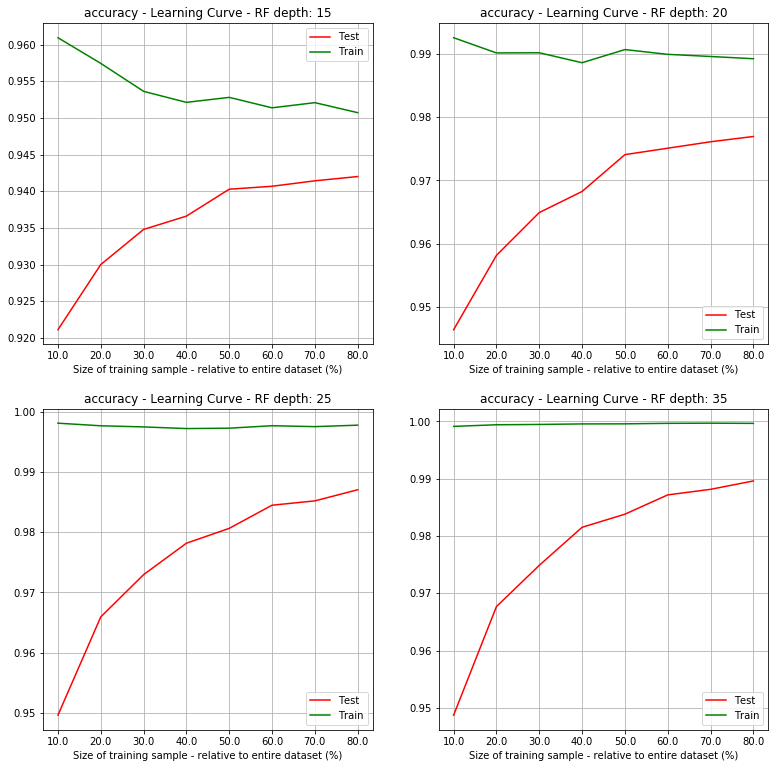

In [58]:
fig = plt.figure(figsize=(13,13))

for i,depth in enumerate([15,20,25,35]):
    ax = fig.add_subplot(2,2,i+1)
    ax_learning_curve(ax,scores_test_rf[6][0][depth][0].accuracy,
                    scores_train_rf[6][0][depth][0].accuracy,'accuracy',100,depth)
    
plt.savefig('RF_accuracy_LearningCurve.png')

plt.show()

Check precision, recall and f1 score of Random Forest Classifier with max depth of 15.

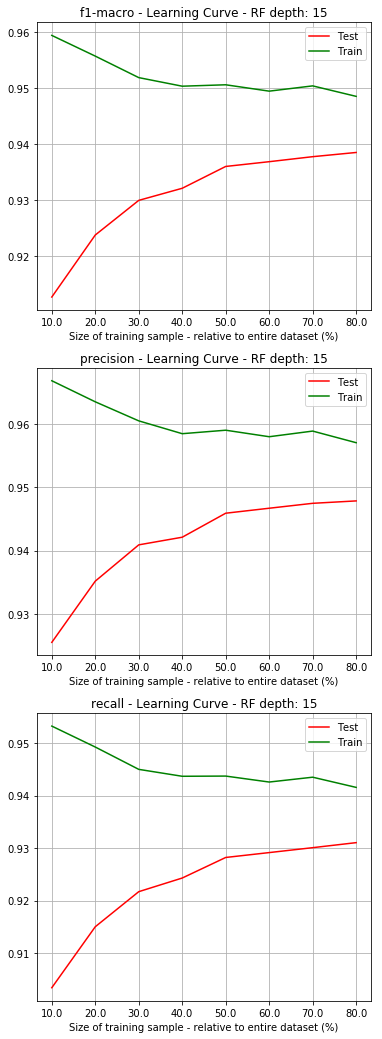

In [59]:
fig = plt.figure(figsize=(6,18))
depth = 15

ax = fig.add_subplot(311)
ax_learning_curve(ax,scores_test_rf[6][0][depth][0].f1,
                    scores_train_rf[6][0][depth][0].f1,'f1-macro',100,depth)
ax = fig.add_subplot(312)
ax_learning_curve(ax,scores_test_rf[6][0][depth][0].precision,
                    scores_train_rf[6][0][depth][0].precision,'precision',100,depth)
ax = fig.add_subplot(313)
ax_learning_curve(ax,scores_test_rf[6][0][depth][0].recall,
                    scores_train_rf[6][0][depth][0].recall,'recall',100,depth)

plt.savefig('RF_MaxDepth15_LearningCurve.png')

plt.show()

Check accuracy with various sensor combinations.

In [ ]:
[a,h,c,a+h,a+c,h+c,a+h+c]

In [157]:
fig = plt.figure(figsize=(13,13))

for i,depth in enumerate([15,20,25,35]):
    ax = fig.add_subplot(2,2,i+1)
    ax_learning_curve(ax,scores_test_rf[1][0][depth][0].accuracy,
                    scores_train_rf[1][0][depth][0].accuracy,'accuracy',100,depth)    

In [ ]:
plt.savefig('RF_Hand&Chest_accuracy_LearningCurve.png')

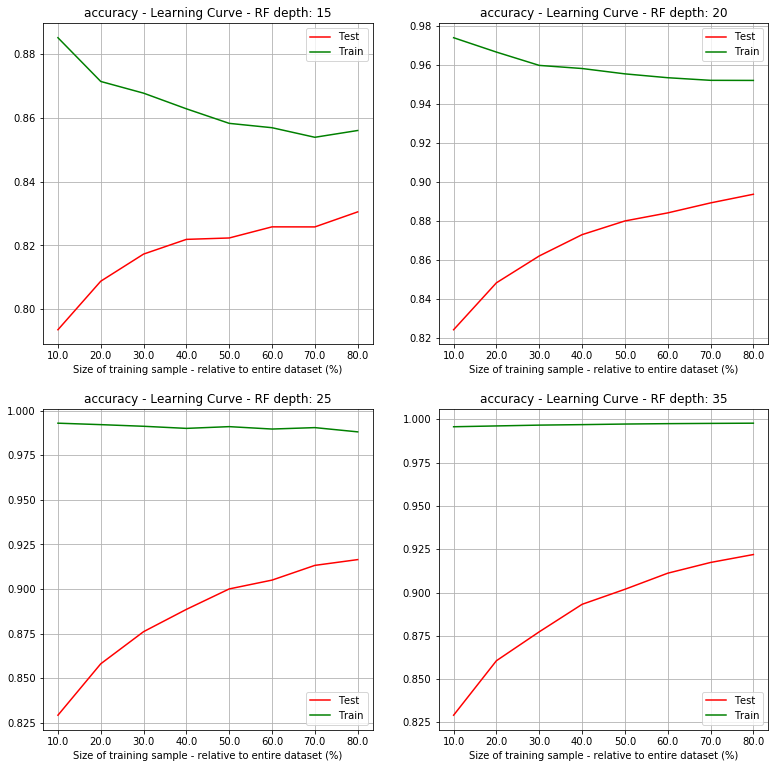

In [158]:
plt.show()

## GRID SEARCH - LightGBM
If you have run the notebook up to and including the Data Exploration section, you can run this section by itself since you should have the pickle with the X and Y data in your system already.

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from timeit import default_timer

import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,train_test_split

import lightgbm as lgb

In [5]:
# Load saved X,y data
with open("Xy.pickle", 'rb') as picklefile: 
    X, y, X_subject = pickle.load(picklefile)

X_tr, X_ts, y_tr, y_ts = train_test_split(X,y, test_size=0.33, random_state=4444,
                                                   stratify=y)
    

h = ['h_x1', 'h_y1', 'h_z1','h_g1', 'h_g2', 'h_g3', 'h_m1', 'h_m2', 'h_m3'] # hand sensor features
c = ['c_x1', 'c_y1', 'c_z1','c_g1', 'c_g2', 'c_g3', 'c_m1', 'c_m2', 'c_m3'] # chest sensor features
a = ['a_x1', 'a_y1', 'a_z1','a_g1', 'a_g2', 'a_g3', 'a_m1', 'a_m2', 'a_m3'] # ankle sensor features

acce= h+c+a  # Features belonging to all sensor

If desired, set variable num_samples to reduce the size of dataset when checking the code runs through the end of the process

In [6]:
num_samples = X_tr.shape[0]
X_train = X_tr[:num_samples]
y_train = y_tr[:num_samples]
X_test = X_ts[:num_samples]
y_test = y_ts[:num_samples]

X_train = X_train[h]
X_test = X_test[h]

Set up dictionary of parameters

In [7]:
ne = [20,40,80,120]
md = [-1]
lr = [0.01,0.1]
mb = [255,510,1020]
bt = ['gbdt','dart']
nb = [50,100]

param_grid = dict(n_estimators=ne, max_depth=md, learning_rate=lr,
                  boosting_type=bt, max_bin=mb,num_boost_round=nb)

Set up classifier

In [8]:
clf = lgb.LGBMClassifier(silent=False,
                         objective='multiclass',
                         num_classes=12,
                         metric = ['multi_error','multi_logloss'],
                         early_stopping_rounds=5)

Run grid search with cross-validation

In [1]:
print('Start Process')
start = default_timer()
# Set up randomized Cross Validated grid search.
grid_lgb = GridSearchCV(clf,
                        param_grid, cv=5,
                        scoring=['f1_macro','recall_macro','precision_macro'],
                        refit=False,n_jobs=-1,verbose=10)

# Fit randomized CV grid
grid_lgb.fit(X_train,y_train)

print('{:.2f}'.format(default_timer()-start))
print('grid_gbc fit')

In [ ]:
results = grid_lgb.cv_results_

In [ ]:
results.keys()

In [ ]:
results['params']

In [ ]:
results['rank_test_f1_macro']

In [ ]:
results['rank_test_precision_macro']

In [ ]:
results['rank_test_recall_macro']

In [ ]:
results['mean_test_f1_macro']

In [ ]:
results['mean_test_precision_macro']

In [ ]:
results['mean_test_recall_macro']

## Feature Engineering
Running Gradient Boosting Classifier was extremely time consumming.
It run 4 days straight on my Mac and did not finish.
I killed my AWS instance and even though was able to create a new instance, I am having Python configuration issues that are preventing me from running my scripts on the cloud.

Therefore I am going to try to do some feature engineering to check if we can achieve greater than 90% accuracy with only one sensor.

For the hand accelerometer, calculate the pitch, roll, and norm of the the raw accelerometer data.

In [45]:
Xh = X[h]
Xh['subject']=X_subject
Xh['activity'] = y
xh = Xh.h_x1.values
yh = Xh.h_y1.values
zh = Xh.h_z1.values

Xh['h_p'] = np.arctan( yh / np.sqrt( xh**2 + zh**2))
Xh['h_r'] = np.arctan( -xh / zh)
Xh['h_n'] = np.sqrt(xh**2 + zh**2 + yh**2)

For each accelerometer, and to capture the temporal nature of the data, segment the data into windows of length 'n' and find the mean and variance each variable over each segment.

In [48]:
Xh.reset_index(drop=True,inplace=True)

In [65]:
window=64

dg = Xh.groupby(by=['subject','activity'])
dg_m = dg.rolling(window).mean()
dg_v = dg.rolling(window).std()
dg_m.reset_index(level=(0,1),drop=True,inplace=True)
dg_m.drop(['subject','activity'],axis=1,inplace=True)
#dg_m.head()

dg_v.reset_index(level=(0,1),drop=True,inplace=True)
dg_v.drop(['subject','activity'],axis=1,inplace=True)
#dg_v.head()

dg_mv = pd.merge(dg_m,dg_v, right_index=True,left_index=True, suffixes=('_m','_v'))

In [66]:
dg_mv = pd.merge(dg_mv,Xh,right_index=True,left_index=True)
dg_mv.dropna(inplace=True)

From the dataset with the rolling window mean and variance extract non-overlapping samples.

In [67]:
dg_s = dg_mv.iloc[0::window,:]
dg_s.dropna(inplace=True)

Xs = dg_s.drop(['subject','activity'],axis=1)
ys = dg_s.activity

In [68]:
Xs.shape,ys.shape

((29934, 36), (29934,))

In [69]:
cols = list(Xs.columns)
cols

['h_x1_m',
 'h_y1_m',
 'h_z1_m',
 'h_g1_m',
 'h_g2_m',
 'h_g3_m',
 'h_m1_m',
 'h_m2_m',
 'h_m3_m',
 'h_p_m',
 'h_r_m',
 'h_n_m',
 'h_x1_v',
 'h_y1_v',
 'h_z1_v',
 'h_g1_v',
 'h_g2_v',
 'h_g3_v',
 'h_m1_v',
 'h_m2_v',
 'h_m3_v',
 'h_p_v',
 'h_r_v',
 'h_n_v',
 'h_x1',
 'h_y1',
 'h_z1',
 'h_g1',
 'h_g2',
 'h_g3',
 'h_m1',
 'h_m2',
 'h_m3',
 'h_p',
 'h_r',
 'h_n']

In [77]:
str_rf = {}
sts_rf = {}
for n in [5,10,15,20]:
    print('Sensor Group: hand - Depth: ',n)
    start = default_timer()
    est = RandomForestClassifier(max_depth=n,random_state=4444,n_jobs=-1)
    #cols = acce
    scores_train, scores_test = learning_curve(est,cols,Xs,ys)
    str_rf.setdefault(n,[]).append(scores_train)
    sts_rf.setdefault(n,[]).append(scores_test)
    print('{:.2f}'.format(default_timer()-start))

Sensor Group: hand - Depth:  5
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
4.72
Sensor Group: hand - Depth:  10
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
5.49
Sensor Group: hand - Depth:  15
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
6.39
Sensor Group: hand - Depth:  20
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
7.20


In [263]:
with open("learningCurves_rf_sample.pickle", 'wb') as picklefile: 
    pickle.dump([str_rf,sts_rf],picklefile)
    
# with open("learningCurves_rf.pickle", 'rb') as picklefile: 
#     scores_train_rf,scores_test_rf = pickle.load(picklefile)

In [78]:
fig = plt.figure(figsize=(13,13))

for i,depth in enumerate([15,20,25,35]):
    ax = fig.add_subplot(2,2,i+1)
    ax_learning_curve(ax,sts_rf[depth][0].accuracy,
                    str_rf[depth][0].accuracy,'accuracy',100,depth)    

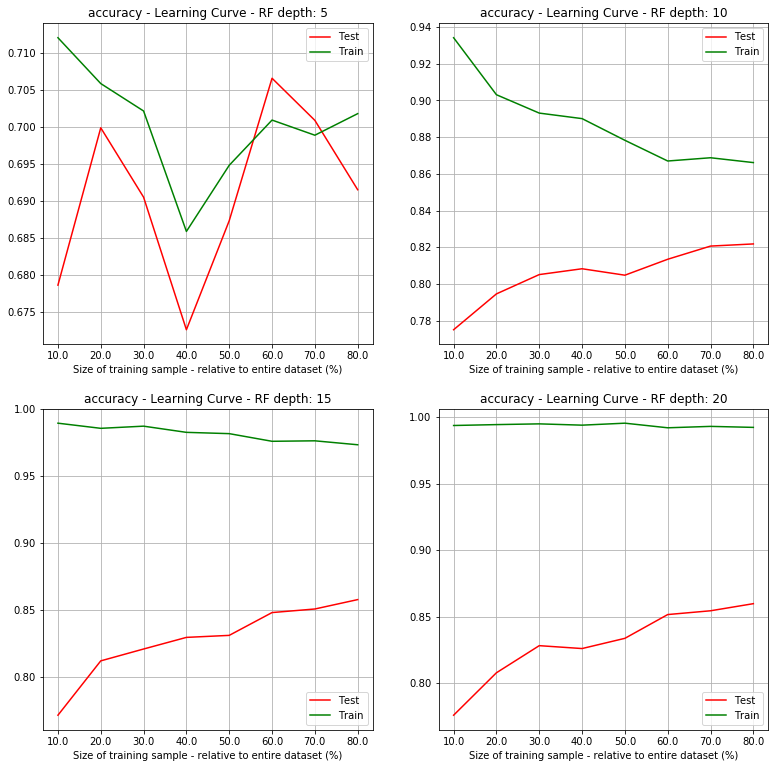

In [79]:
#plt.savefig('RF_Hand_FeatureEng_Win16_LearningCurve.png')
plt.show()

In [ ]:
plt.savefig('RF_Hand_sample_accuracy_LearningCurve.png')

In [145]:
sts_rf[15][0]

,f1,precision,recall,accuracy
0,0.729711,0.756683,0.724084,0.767445
1,0.750827,0.777644,0.744808,0.785444
2,0.756543,0.785309,0.748721,0.787703
3,0.764576,0.794094,0.756603,0.794127
4,0.766477,0.798328,0.758494,0.796334
5,0.775685,0.804768,0.767997,0.803069
6,0.775944,0.807485,0.767628,0.804224
7,0.776899,0.808582,0.768751,0.804912


In [31]:
cols = h

In [40]:
str_rf = {}
sts_rf = {}
for n in [15,20,25,35]:
    print('Sensor Group: hand - Depth: ',n)
    start = default_timer()
    est = lgb.LGBMClassifier(silent=False, max_depth=n,n_estimators=30)
    #cols = acce
    scores_train, scores_test = learning_curve(est,cols,X_train,y_train)
    str_rf.setdefault(n,[]).append(scores_train)
    sts_rf.setdefault(n,[]).append(scores_test)
    print('{:.2f}'.format(default_timer()-start))

Sensor Group: hand - Depth:  15
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
233.60
Sensor Group: hand - Depth:  20
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
242.33
Sensor Group: hand - Depth:  25
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
231.40
Sensor Group: hand - Depth:  35
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
233.42


In [42]:
fig = plt.figure(figsize=(13,13))

for i,depth in enumerate([15,20,25,35]):
    ax = fig.add_subplot(2,2,i+1)
    ax_learning_curve(ax,sts_rf[depth][0].accuracy,
                    str_rf[depth][0].accuracy,'accuracy',100,depth)    

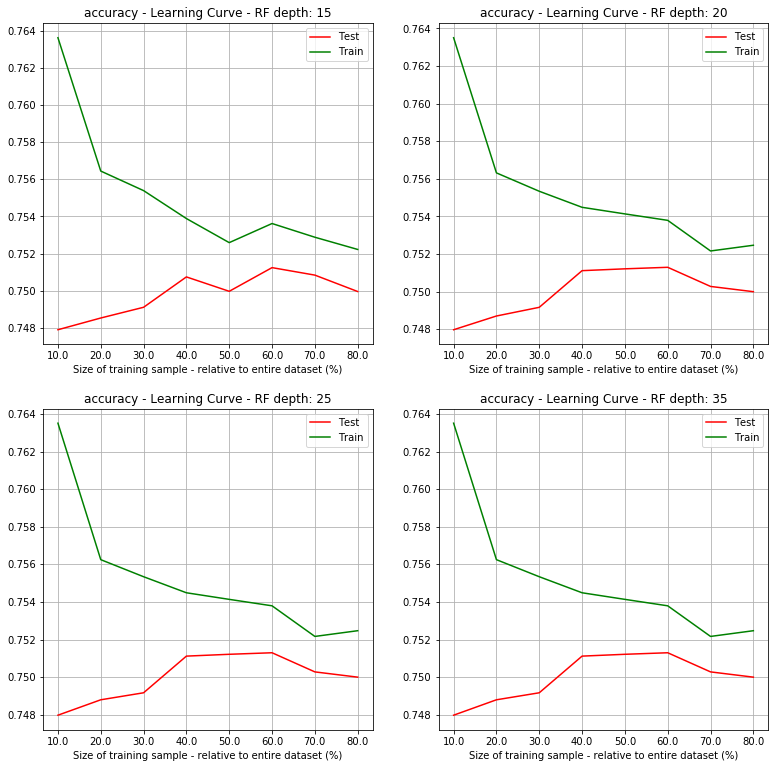

In [43]:
plt.show()

In [ ]:
str_rf = {}
sts_rf = {}
for n in [15,20,25,35]:
    print('Sensor Group: hand - Depth: ',n)
    start = default_timer()
    est = lgb.LGBMClassifier(silent=False, max_depth=n,n_estimators=30)
    #cols = acce
    scores_train, scores_test = learning_curve(est,cols,X_train,y_train)
    str_rf.setdefault(n,[]).append(scores_train)
    sts_rf.setdefault(n,[]).append(scores_test)
    print('{:.2f}'.format(default_timer()-start))

## GRID SEARCH - Random Forest and Gradient Boosting Classifer
Tried grid search over random forest and over gradient boosting classifier.
### Load dataset and initialize grid parameters

In [220]:
# # Load saved X,y data
# import pickle
# with open("Xy.pickle", 'rb') as picklefile: 
#     X_train, X_test, y_train, y_test,X,y,X_subject = pickle.load(picklefile)

In [221]:
# # Create smaller training set from original train-test split.

# X_train2, _ , y_train2, _ = train_test_split(X_train, y_train, train_size=0.02,
#                                              random_state=4444, stratify=y_train)

In [222]:
# # Create grid
# ne = [16,32,64,128]
# md = [4,8,16,32]
# mf = [4,8,12]
# cr = ['gini','entropy']

# param_grid_tree = dict(n_estimators= ne, criterion=cr,max_depth=md,
#                  max_features = mf)# number of combinations = 96

# param_grid_gbc = dict(n_estimators= ne,max_depth=md,max_features = mf) # number of combinations = 48

### Randomized Grid Search with Cross Validation

In [223]:
# # Set up randomized Cross Validated grid search.
# from sklearn.model_selection import GridSearchCV

# grid_tree = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), param_grid_tree, cv=2,
#                           scoring=['f1_macro','recall_macro','precision_macro'],refit=False,
#                           n_jobs=-1,random_state=4444,
#                           n_iter=2)

In [224]:
# # Fit randomized CV grid
# %timeit grid_tree.fit(X_train[c],y_train)

In [225]:
# with open('tree_randomSearchCV.pickle', 'wb') as f: 
#     pickle.dump(grid_tree,f )

In [226]:
# # Set up randomized Cross Validated grid search.
# grid_gbc = RandomizedSearchCV(GradientBoostingClassifier, param_grid_gbc, cv=5,
#                           scoring=['f1_macro','recall_macro','precision_macro'],refit=False,
#                           n_jobs=-1,random_state=4444,
#                           n_iter=2)

In [227]:
# %timeit grid_gbc.fit(X_train2[c],y_train2)

In [228]:
# with open('gbc_randomSearchCV.pickle', 'wb') as f: 
#     pickle.dump(grid_gbc,f )